In [24]:
from libraries import *
from parameters import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import FastICA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot

In [25]:
os.getcwd()
os.chdir(projectDir)

In [26]:
adata = sc.read_h5ad('./DATA/sc_training.h5ad')

In [27]:
## Remove KOs that have less than 15 cells
kk = adata.obs.condition.value_counts()[adata.obs.condition.value_counts() < 15]
adata = adata[[x not in kk.index for x in adata.obs.condition],:].copy()

testKOs = ['Ets1', 'Fosb', 'Mafk', 'Stat3']
validationKOs = ['Aqr', 'Bach2', 'Bhlhe40'] 

trainKOs = adata.obs.condition.unique()

## Remove KO genes that are not expressed
notavailKOs = [x for x in trainKOs if x not in adata.var_names]
adata = adata[[x not in ['Fzd1', 'P2rx7'] for x in adata.obs.condition],:].copy()

trainKOs = adata.obs.condition.unique()
trainKOs = [x for x in trainKOs if x not in ['Unperturbed']]


allKOs = trainKOs + validationKOs + testKOs

Identify marker genes of the cell states

In [28]:
adata.X = adata.layers['rawcounts'].copy()
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata, max_value=10)

sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, metric="euclidean")

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)
sc.tl.diffmap(adata)

sc.tl.rank_genes_groups(adata, groupby="state", n_genes=2000, method="t-test_overestim_var")
markerGenes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
markerGenes = markerGenes.iloc[0:10,:]

markerGenes = list(markerGenes.melt().value)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)
computing Diffusio

/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Generate response matrix

In [29]:
myDF_2 = pd.crosstab(adata.obs.condition,
                     adata.obs.state)
Y = myDF_2.div(myDF_2.sum(axis=1), axis=0)
Y = Y[['progenitor', 
       'effector',
       'terminal exhausted',
       'cycling',
       'other']]

Cluster the KOs based on the cell state percent distribution

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP


/tmp/ipykernel_28137/4177790228.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  respAnnDat = sc.AnnData(X=Y)
/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


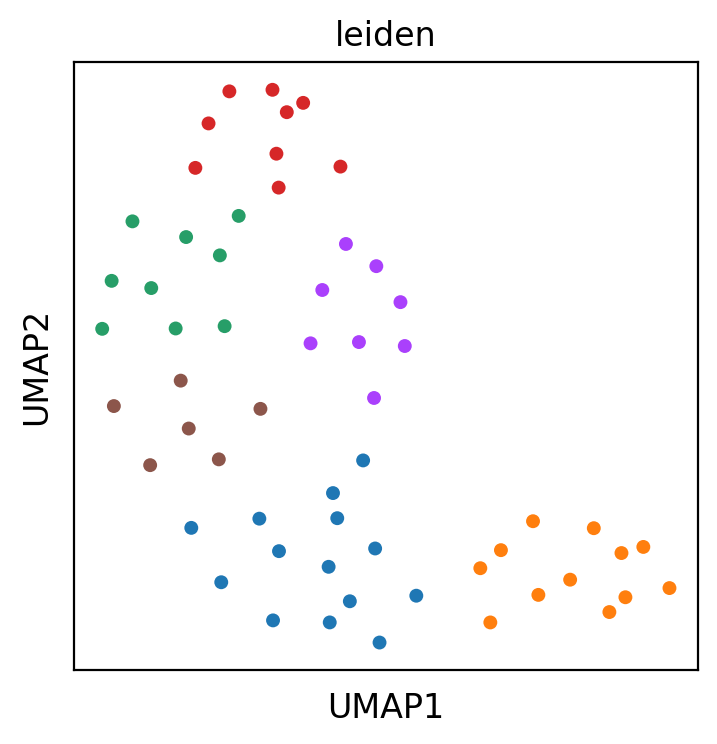

In [30]:
respAnnDat = sc.AnnData(X=Y)
#sc.pp.scale(koGuidesAnnDat)
#sc.pp.pca(respAnnDat, svd_solver='arpack')
sc.pp.neighbors(respAnnDat)
sc.tl.leiden(respAnnDat, resolution=1.5)
sc.tl.umap(respAnnDat)
sc.pl.umap(respAnnDat, 
           color='leiden',
           size=100,  
           legend_fontoutline=3, 
           legend_loc = 'center',
           legend_fontsize=14,
           legend_fontweight='normal')

In [31]:
KOClusters = respAnnDat.obs
KOClusters = KOClusters.sort_values(by=['leiden'])

Visualize the covariance of the KOs based on the response variable

<AxesSubplot:xlabel='condition', ylabel='condition'>

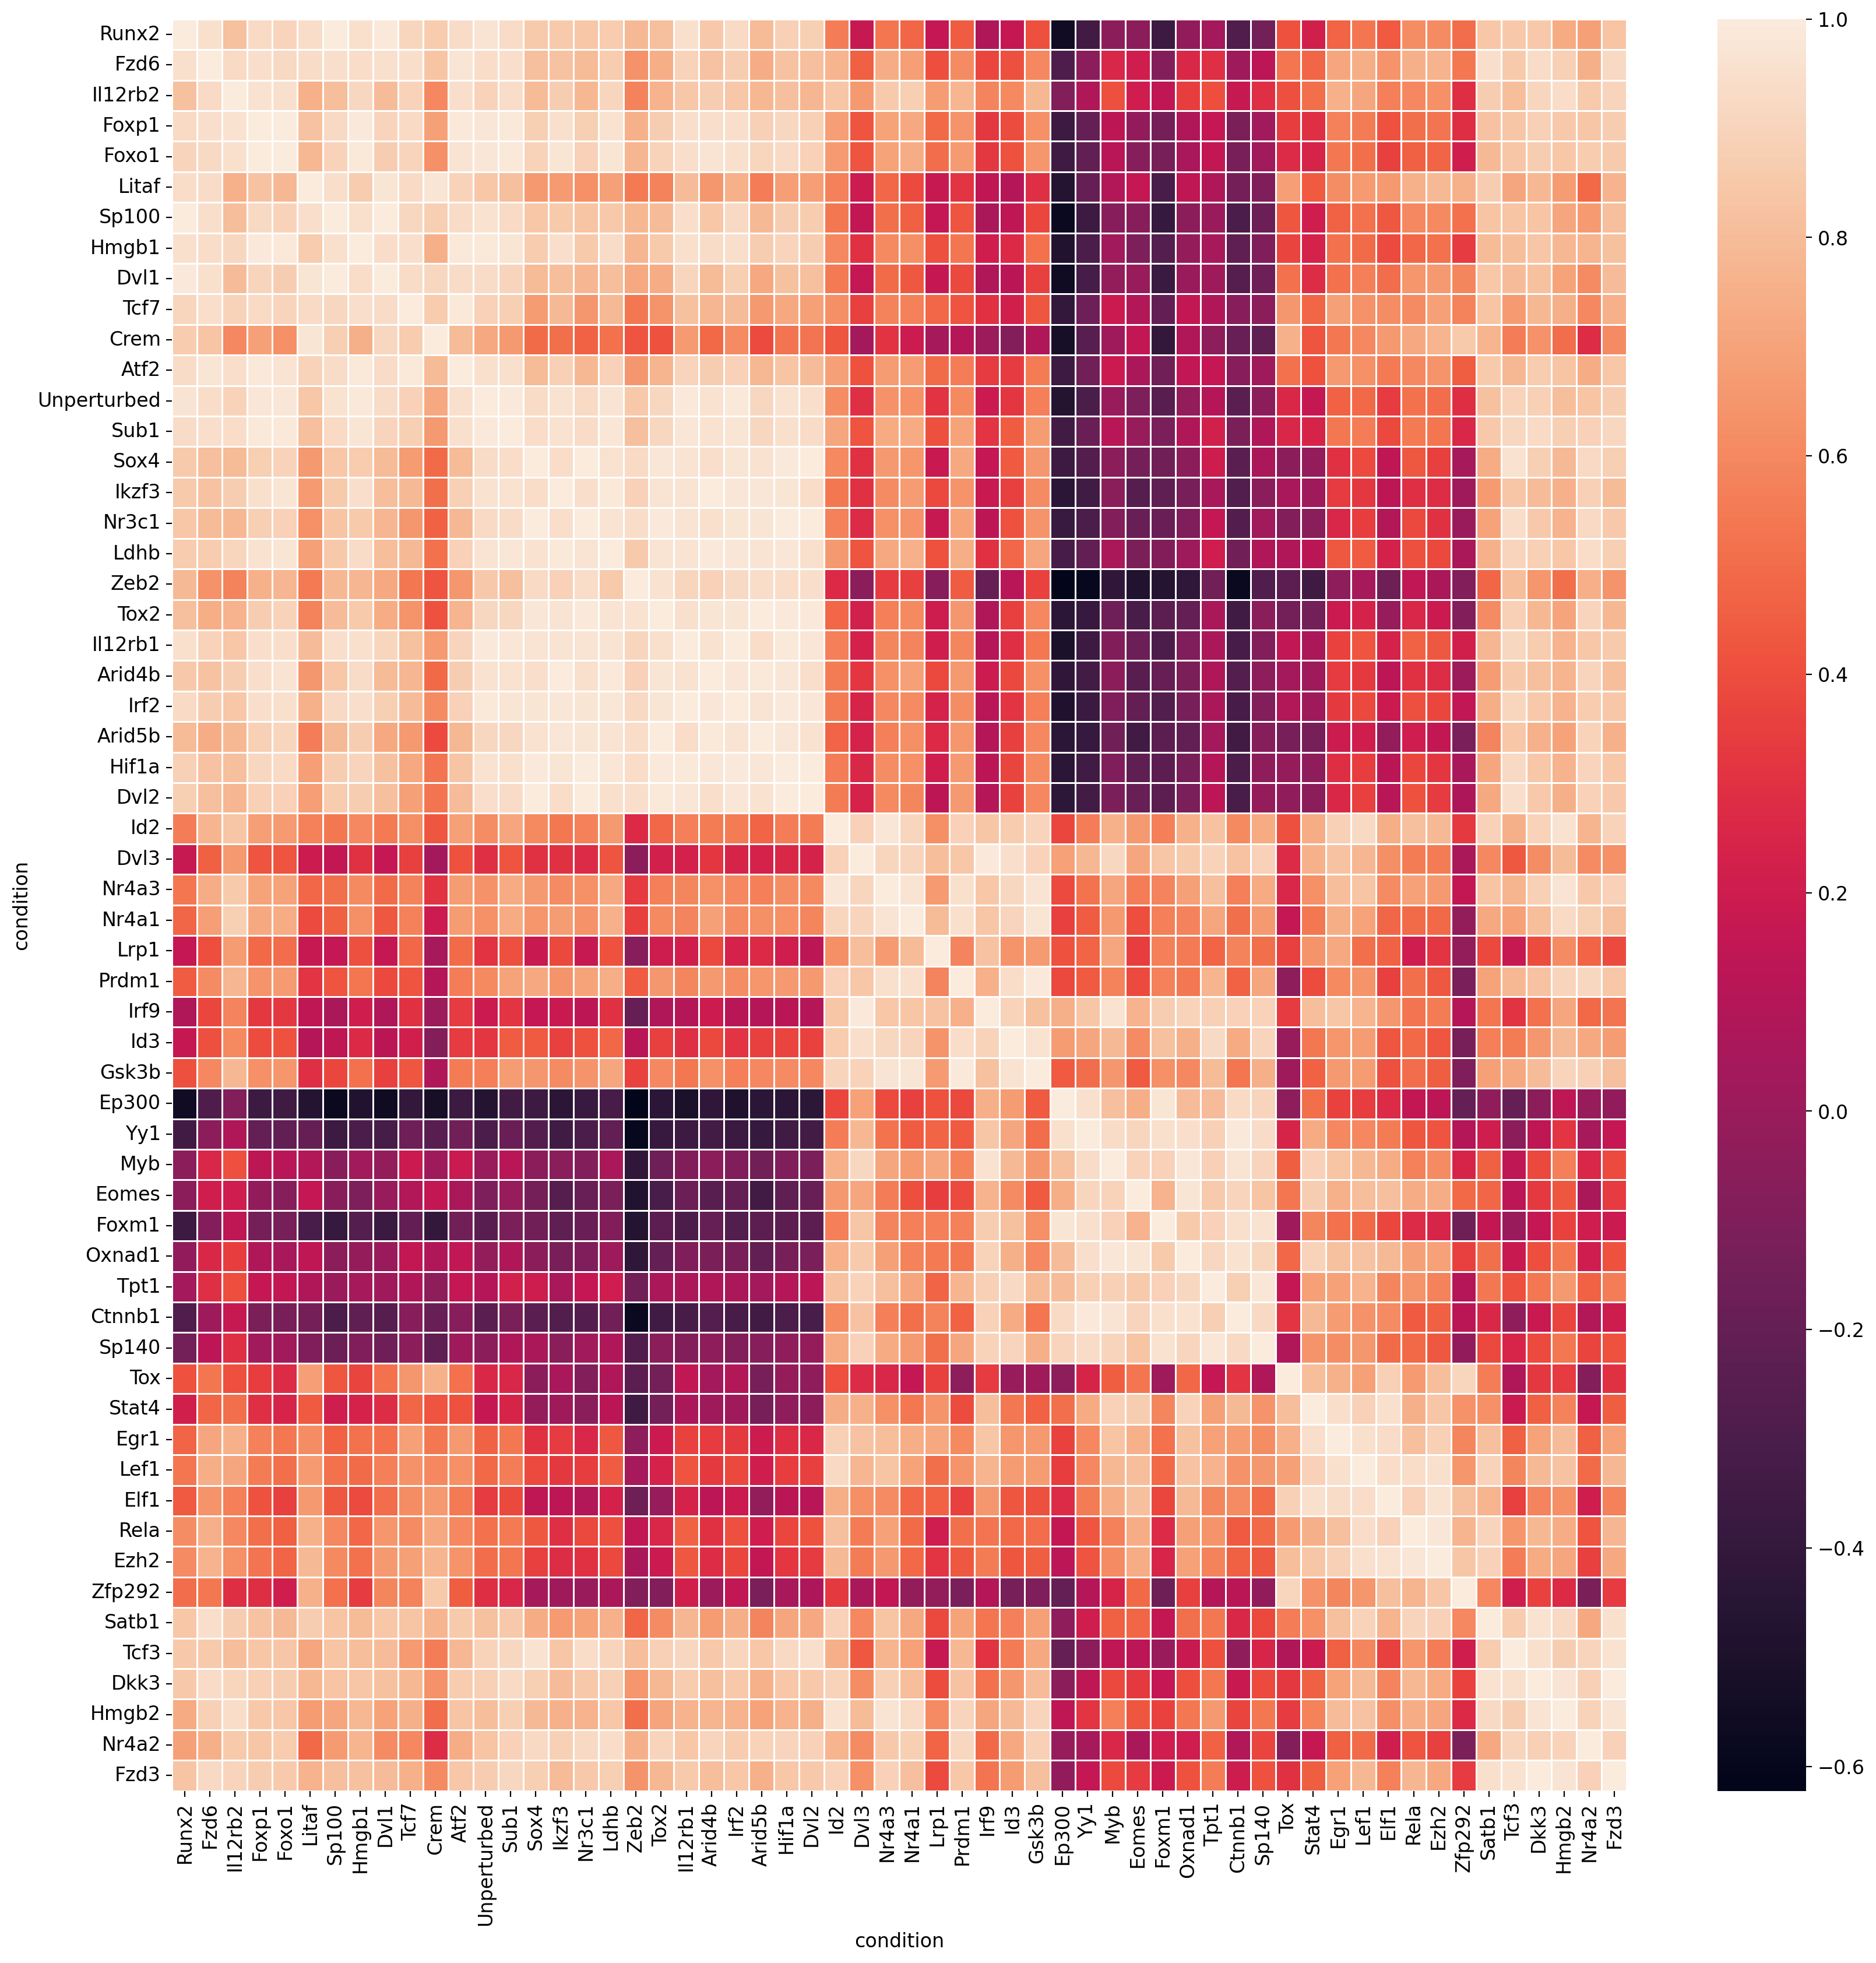

In [32]:
M = pd.DataFrame(np.corrcoef(Y))
M.index = Y.index
M.columns = Y.index
M = M.loc[KOClusters.index, KOClusters.index]
 

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(M,  linewidths=.5, ax=ax)

Generate the correlation matrix between the KO genes and the marker genes

In [33]:
expVar = pd.DataFrame(adata.X)
expVar.columns = adata.var_names

geneList = [x for x in list(set(allKOs+markerGenes)) if x in expVar.columns] 
myGenesExp = expVar.loc[:,geneList]
corCoefs = pd.DataFrame(np.corrcoef(np.transpose(myGenesExp)))

corCoefs.columns = geneList
corCoefs.index = geneList

corCoefs.replace(np.nan, 0, inplace=True)
corCoefs = corCoefs.loc[allKOs,markerGenes]

koClustersOrder = [x for x in KOClusters.index if x in corCoefs.index]

Identify the markes genes whose correlation with the KO genes are informative

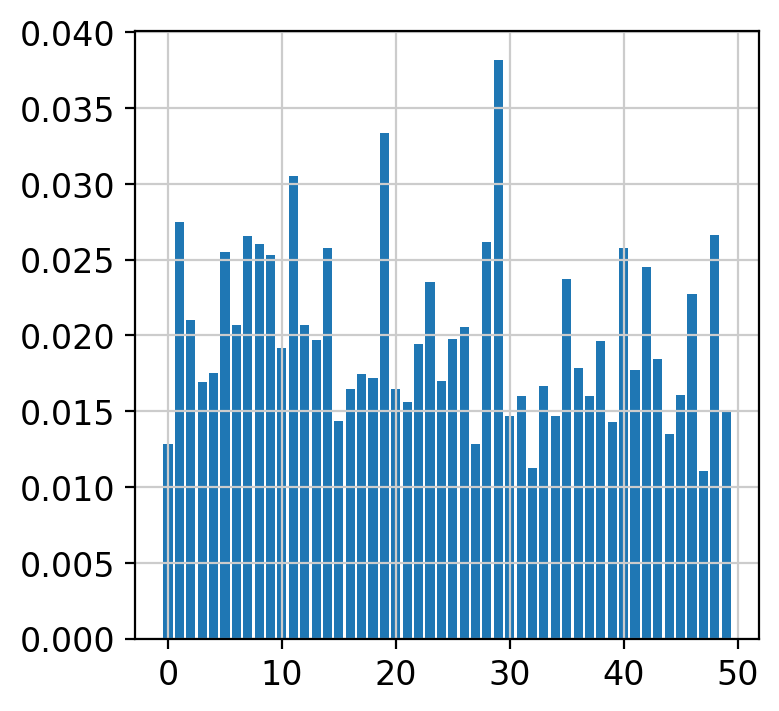

2


/home/eraslab1/miniconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


MAE: 0.089 (0.015)
3
MAE: 0.084 (0.014)
4
MAE: 0.084 (0.014)
5
MAE: 0.081 (0.014)
6
MAE: 0.080 (0.013)
7
MAE: 0.080 (0.013)
8
MAE: 0.081 (0.013)
9
MAE: 0.080 (0.012)
10
MAE: 0.080 (0.012)
11
MAE: 0.080 (0.012)
12
MAE: 0.081 (0.012)
13
MAE: 0.081 (0.012)
14
MAE: 0.082 (0.013)
15
MAE: 0.084 (0.013)
16
MAE: 0.084 (0.014)
17
MAE: 0.084 (0.014)
18
MAE: 0.084 (0.013)
19
MAE: 0.084 (0.014)
20
MAE: 0.085 (0.014)
21
MAE: 0.086 (0.014)
22
MAE: 0.086 (0.014)
23
MAE: 0.086 (0.015)
24
MAE: 0.086 (0.015)
25
MAE: 0.086 (0.015)
26
MAE: 0.086 (0.014)
27
MAE: 0.086 (0.014)
28
MAE: 0.086 (0.014)
29
MAE: 0.086 (0.014)
30
MAE: 0.086 (0.014)
31
MAE: 0.086 (0.014)
32
MAE: 0.086 (0.014)
33
MAE: 0.086 (0.014)
34
MAE: 0.086 (0.014)
35
MAE: 0.087 (0.014)
36
MAE: 0.086 (0.014)
37
MAE: 0.086 (0.014)
38
MAE: 0.086 (0.014)
39
MAE: 0.086 (0.014)
40
MAE: 0.086 (0.014)
41
MAE: 0.086 (0.014)
42
MAE: 0.086 (0.014)
43
MAE: 0.086 (0.014)
44
MAE: 0.086 (0.014)
45
MAE: 0.087 (0.014)
46
MAE: 0.086 (0.014)
47
MAE: 0.086 (0.014

In [34]:
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(corCoefs.loc[koClustersOrder,], KOClusters.loc[koClustersOrder,].values.ravel())

importance = forest.feature_importances_
sorted_indices = np.argsort(importance)[::-1]

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


for i in range(2,len(corCoefs.columns),1):
    print(i)
    myX =  corCoefs.iloc[:,sorted_indices[0:i]]
    
    X_train = myX.loc[trainKOs, ]
    Y = Y.loc[X_train.index,:]
        
    model = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=2)
        
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    n_scores = cross_val_score(model, X_train, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores = absolute(n_scores)
    
    print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Select the top 10 informative marker genes

In [35]:
markerCoefs_reduced = corCoefs.iloc[:,sorted_indices[0:10]]

Identify the effect of each KO on the genes correcting for possible confounders

In [36]:
guideMatrix = pd.get_dummies(data=adata.obs.condition, drop_first=False)
guideMatrix = guideMatrix.drop(['Unperturbed'], axis=1)
guideMatrix = guideMatrix.join(adata.obs[["n_genes", "mt_frac"]])
stateMat = pd.get_dummies(data=adata.obs.state, drop_first=False)
stateMat.columns=["cycling", "effector", "other", "progenitor", "exhausted"]
stateMat = stateMat.drop(['progenitor'], axis=1)
guideMatrix = guideMatrix.join(stateMat)
    
    
expressionMatrix = pd.DataFrame(adata.X)
expressionMatrix.columns = adata.var_names
expressionMatrix.index = adata.obs.index

expressionMatrix = expressionMatrix[allKOs]

myFormula = "+".join(guideMatrix.columns)
my_formula = "y~" + myFormula

my_formula

allRes = pd.DataFrame()


for i in range(0,len(expressionMatrix.columns),1):
    #print(i)
    guideMatrix["y"] = np.array(expressionMatrix)[:,i]

    mod1 = smf.ols(formula=my_formula, data=guideMatrix).fit()

    k = mod1.summary()
    res = pd.DataFrame( k.tables[1])
    res["respGene"] = expressionMatrix.columns[i]

    allRes = pd.concat([allRes,res])
allRes.columns = ['guides', 'coef', 'stderr', 'z', 'pval', '[0.025', '0.975', 'respGene'] 
allRes = allRes[['guides', 'coef',  'pval','respGene']]

allRes.to_csv("Regres.csv")
allRes = pd.read_csv("Regres.csv", index_col=0)

allRes = allRes.loc[~allRes.guides.isin(['Intercept', 'n_genes', 'mt_frac', 'NaN', 
                                         'cycling', 'effector', 'other', 'exhausted']) & 
                ~allRes.guides.isnull() &  
                ~allRes.guides.str.contains("leiden", case=False, na=False)]

coefs = pd.pivot(allRes[['guides','coef', 'respGene']],
                 index='guides', columns='respGene', 
                 values='coef')
coefs = coefs.loc[coefs.index.isin(coefs.columns),]
coefs = coefs.astype(float)


pvals = pd.pivot(allRes[['guides','pval', 'respGene']],
                 index='guides', columns='respGene', 
                 values='pval')
pvals = pvals.loc[pvals.index.isin(pvals.columns),]
pvals = pvals.astype(float)


In [37]:
coefs.iloc[pvals > 0.1] = 0

/tmp/ipykernel_28137/2645836945.py:1: FutureWarning: DataFrame indexer for .iloc is deprecated and will be removed in a future version.
consider using .loc with a DataFrame indexer for automatic alignment.
  coefs.iloc[pvals > 0.1] = 0


In [38]:
coefs = coefs.loc[:,list(trainKOs)+testKOs+validationKOs].T
pvals = pvals.loc[:,list(trainKOs)+testKOs+validationKOs].T

In [39]:
pca = PCA(n_components=25)
pca.fit(coefs)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

coefs_reduced = pd.DataFrame(pca.fit_transform(coefs))
coefs_reduced.index = coefs.index
coefs_reduced.columns = ["pcaCoef" + str(x) for x in range(0,len(coefs_reduced.columns),1)] 

[0.2227679031 0.1232510835 0.0801248291 0.0662149094 0.0570335323
 0.0472145839 0.041354188  0.0319110393 0.0314455298 0.0294249394
 0.0257505352 0.0254007364 0.0206286356 0.0199037549 0.01657497
 0.0157801388 0.0149947024 0.0125492827 0.012086245  0.0103599957
 0.0094298912 0.0086292218 0.0077411127 0.0071814336 0.0061762517]
0.9439294452723476


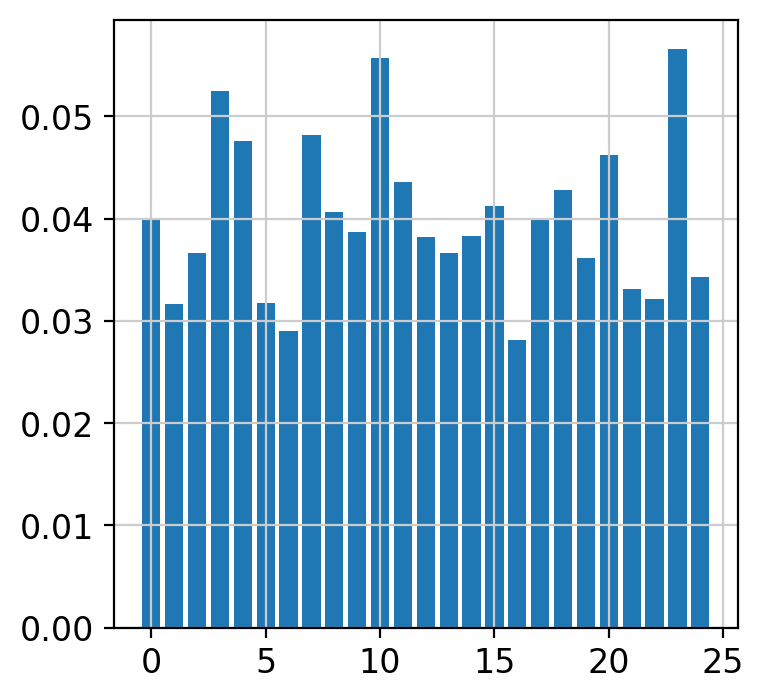

2
[0.0743374629 0.0815830442 0.0735092726 0.0845559153 0.090955357
 0.0566472604 0.0731219322 0.0802466437 0.0970308413 0.0796370699
 0.0851174308 0.0777914256 0.0791073267 0.1041472082 0.0738045043]
MAE: 0.081 (0.011)
3
[0.0726423195 0.0815284239 0.0736810616 0.086079836  0.0885994808
 0.0589401936 0.0712503417 0.0803153203 0.0983888858 0.0791955975
 0.0832154184 0.0766730286 0.0794201892 0.104498807  0.0744660712]
MAE: 0.081 (0.011)
4
[0.073492007  0.0802207348 0.0753616438 0.0825677247 0.0851960367
 0.0558145544 0.0733873311 0.0805263193 0.0985884565 0.0797638402
 0.0826829706 0.0755177621 0.0816335759 0.1054849862 0.0704068289]
MAE: 0.080 (0.011)
5
[0.0738851701 0.0826037407 0.0747982495 0.0833940208 0.0881819674
 0.0557466923 0.073282142  0.0817904912 0.1014018815 0.0795031641
 0.0812533821 0.0779425453 0.0830545103 0.1056000715 0.0707402545]
MAE: 0.081 (0.012)
6
[0.0747460246 0.0813996911 0.0752279085 0.0831934636 0.0879565489
 0.0552991392 0.0745365317 0.0824461253 0.1061904614 

In [40]:
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(coefs_reduced.loc[koClustersOrder,], KOClusters.loc[koClustersOrder,].values.ravel())

importance = forest.feature_importances_
sorted_indices = np.argsort(importance)[::-1]

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

for i in range(2,25,1):
    print(i)
    coefs_reduced_tmp = coefs_reduced.iloc[:,sorted_indices[0:i]]

    myX =  pd.concat([coefs_reduced_tmp.loc[markerCoefs_reduced.index,:], markerCoefs_reduced], axis=1)
    myX_scaled = pd.DataFrame(StandardScaler(with_std=False).fit(myX).transform(myX.astype(float)))
    myX_scaled.index = myX.index
    myX_scaled.columns = myX.columns
    
    
    X_train = myX_scaled.loc[trainKOs, ]
    Y = Y.loc[X_train.index,:]
    
    model = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=2)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    n_scores = cross_val_score(model, X_train, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    n_scores = absolute(n_scores)
    
    print(n_scores)
    
    print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [41]:
myX =  pd.concat([coefs_reduced.loc[markerCoefs_reduced.index,:], markerCoefs_reduced], axis=1)
myX_scaled = pd.DataFrame(StandardScaler(with_std=False).fit(myX).transform(myX.astype(float)))
myX_scaled.index = myX.index
myX_scaled.columns = myX.columns
 
X_train = myX_scaled.loc[trainKOs, ]
Y = Y.loc[X_train.index,:]

model = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=2)
model.fit(X_train,Y)

valPreds = pd.DataFrame(model.predict(X_train))

In [42]:
X_val = myX_scaled.loc[validationKOs, ]
valPreds = pd.DataFrame(model.predict(X_val))
valPreds.index=validationKOs
#valPreds.to_csv("validation_output.csv")
valPreds

,0,1,2,3,4
Aqr,0.410260,0.190892,0.172197,0.220456,0.006195
Bach2,0.264425,0.180276,0.233908,0.307683,0.013708
Bhlhe40,0.175854,0.228412,0.243464,0.336308,0.015961


In [43]:
X_test = myX_scaled.loc[testKOs, ]
testPreds = pd.DataFrame(model.predict(X_test))
testPreds.index = testKOs
#testPreds.to_csv("test_output.csv")
testPreds

,0,1,2,3,4
Ets1,0.113761,0.179525,0.308848,0.380812,0.017053
Fosb,0.167064,0.179726,0.279972,0.352778,0.020460
Mafk,0.198038,0.197974,0.266278,0.320449,0.017262
Stat3,0.425543,0.169495,0.168516,0.222724,0.013722


In [44]:
testPreds.sum(axis=1)

Ets1     1.0
Fosb     1.0
Mafk     1.0
Stat3    1.0
dtype: float64